In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [22]:
# Data
np.random.seed(42)
data = {
    'Day_of_Week': [(i % 7) + 1 for i in range(61)],
    'Customers': np.random.randint(248, 284, size=61),
    'Sales': np.zeros(61)
}
df = pd.DataFrame(data)
df['Sales'] = df['Customers'] * 1200 + np.random.randint(-20000, 20000, size=61)
df['Sales'] = df['Sales'].clip(300000, 450000)
print("Table:\n", df.head())


Table:
    Day_of_Week  Customers   Sales
0            1        276  337051
1            2        262  300000
2            3        255  310253
3            4        268  325876
4            5        266  322447


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Day_of_Week  61 non-null     int64
 1   Customers    61 non-null     int32
 2   Sales        61 non-null     int32
dtypes: int32(2), int64(1)
memory usage: 1.1 KB


In [8]:
# Clean
print("Missing:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
print("Types:\n", df.dtypes)


Missing:
 Day_of_Week    0
Customers      0
Sales          0
dtype: int64
Duplicates: 0
Types:
 Day_of_Week    int64
Customers      int32
Sales          int32
dtype: object


Skew Before:
Day_of_Week: 0.05
Customers: 0.09
Sales: 0.34
Log_Customers: 0.04
Log_Sales: 0.28
New Table:
    Day_of_Week  Customers   Sales  Log_Customers  Log_Sales
0            1        276  337051       5.624018  12.727993
1            2        262  300000       5.572154  12.611541
2            3        255  310253       5.545177  12.645147
3            4        268  325876       5.594711  12.694275
4            5        266  322447       5.587249  12.683697


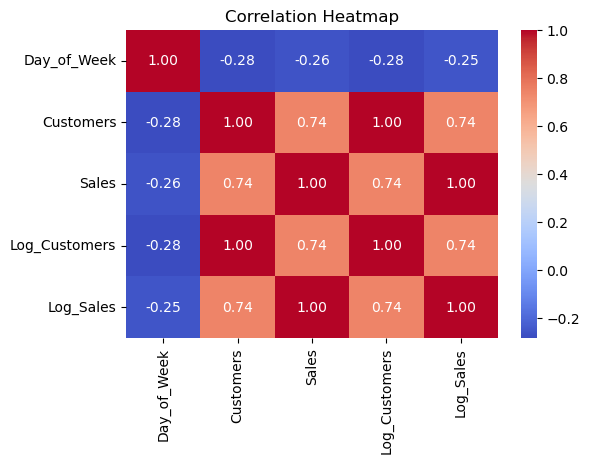

In [11]:
# Transform
print("Skew Before:")
for col in df.columns:
    print(f"{col}: {df[col].skew():.2f}")
df['Log_Customers'] = np.log1p(df['Customers'])
df['Log_Sales'] = np.log1p(df['Sales'])
print("New Table:\n", df.head())

# Visualize

plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


In [12]:
# Assumptions
X = df[features]
y = df['Sales']
vif_data = pd.DataFrame()
vif_data['Clue'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:\n", vif_data)


VIF:
           Clue       VIF
0  Day_of_Week  4.700202
1    Customers  4.700202


In [13]:
# Train & Predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
print("Helpers:\n", pd.DataFrame(model.coef_, X.columns, columns=['Score']))


MSE: 94272921.76232068
R²: 0.4498298105930325
Helpers:
                    Score
Day_of_Week  -593.813211
Customers    1147.094254


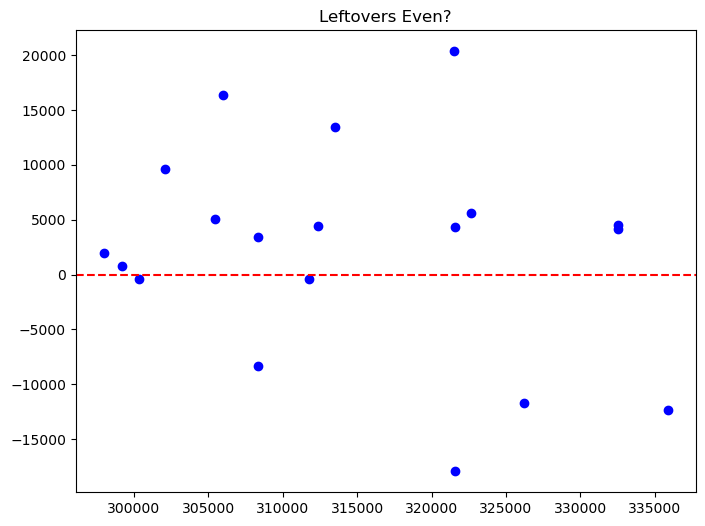

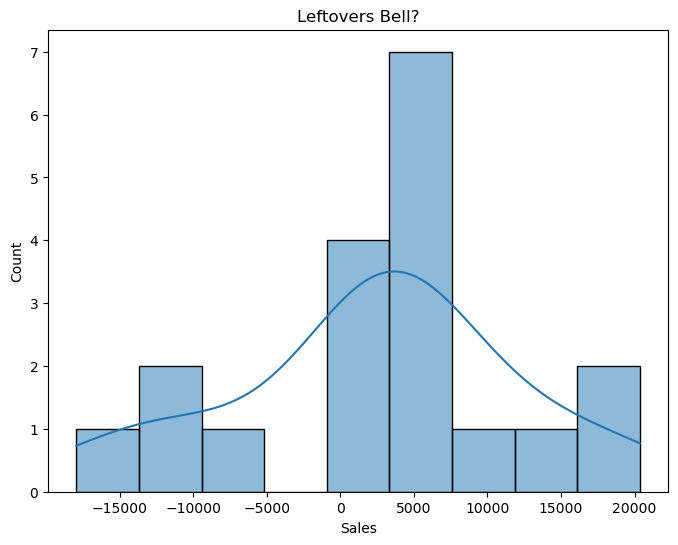

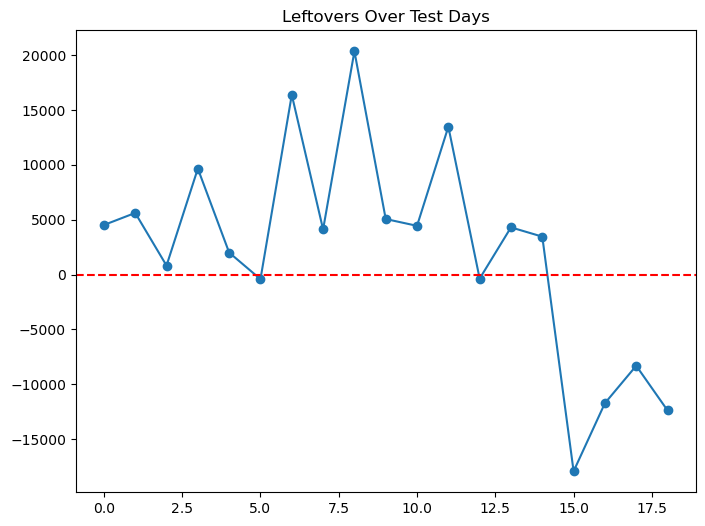

In [14]:
# Check Leftovers
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Leftovers Even?")
plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Leftovers Bell?")
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), residuals, marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Leftovers Over Test Days")
plt.show()



In [16]:
# Improve
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
print("Fancy MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Fancy R²:", r2_score(y_test, y_pred_ridge))
print("Real vs. Predicted:\n", pd.DataFrame({'Real': y_test.values, 'Predicted': y_pred_ridge}).head())

Fancy MSE: 97352961.39893004
Fancy R²: 0.43185491431765655
Real vs. Predicted:
      Real      Predicted
0  337051  335018.157102
1  328300  323293.600371
2  300000  298369.637836
3  311735  300282.865965
4  300000  302051.870353


Sales Guesses for Next 20 Days:
    Day_of_Week  Customers  Predicted_Sales
0             6        283    337592.024791
1             7        266    317497.609262
2             1        273    329090.148306
3             2        250    302113.167254
4             3        266    319872.862107
5             4        267    320426.143150
6             5        279    333597.460986
7             6        254    304326.291426
8             7        280    333556.928818
9             1        265    319913.394275
10            2        248    299818.978747
11            3        258    310696.108075
12            4        275    329602.897181
13            5        272    325567.801208
14            6        270    322679.799489
15            7        278    331262.740310
16            1        277    333678.525322
17            2        282    338820.183381
18            3        254    306107.731059
19            4        263    315837.766134


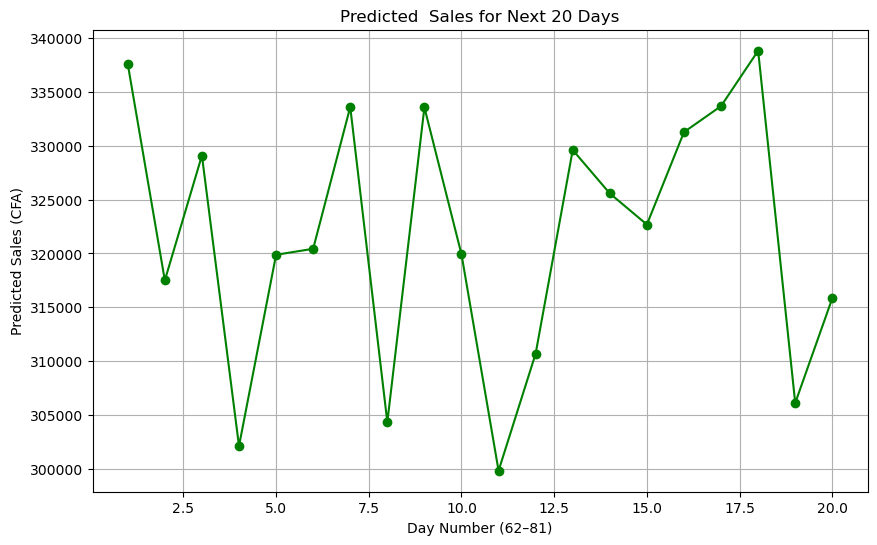

In [20]:
future_days = {
    'Day_of_Week': [(i % 7) + 1 for i in range(61, 81)],  
    'Customers': np.random.randint(248, 284, size=20)      
}
future_df = pd.DataFrame(future_days)  # New table

# Step 3: Let Robot Guess Sales
future_sales = model.predict(future_df)  # Robot guesses for new days
future_df['Predicted_Sales'] = future_sales  # Add guesses to table

# Step 4: Show the Guesses
print("Sales Guesses for Next 20 Days:")
print(future_df)

# Step 5: Draw a Picture
plt.figure(figsize=(10, 6))  # Big paper
plt.plot(range(1, 21), future_df['Predicted_Sales'], marker='o', color='green')  # Line with dots
plt.title("Predicted  Sales for Next 20 Days")
plt.xlabel("Day Number (62–81)")
plt.ylabel("Predicted Sales (CFA)")
plt.grid(True)  # Add lines like a checkerboard